In [3]:
from pmdarima import auto_arima

In [5]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from statsmodels.tools.eval_measures import rmse


#ignore informations warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [6]:
# Read in the given data and set the index column to the date column and parse the dates
df=pd.read_csv("../../02_data_acquisition_understanding/01_data_source/sickness_table.csv", index_col="date", parse_dates=True ) 
df.index.freq="D" #Set the frequence to Daily
df.index

DatetimeIndex(['2016-04-01', '2016-04-02', '2016-04-03', '2016-04-04',
               '2016-04-05', '2016-04-06', '2016-04-07', '2016-04-08',
               '2016-04-09', '2016-04-10',
               ...
               '2019-05-18', '2019-05-19', '2019-05-20', '2019-05-21',
               '2019-05-22', '2019-05-23', '2019-05-24', '2019-05-25',
               '2019-05-26', '2019-05-27'],
              dtype='datetime64[ns]', name='date', length=1152, freq='D')

In [7]:
auto_arima(df['calls'],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1152
Model:             SARIMAX(1, 1, 2)x(2, 0, [1], 7)   Log Likelihood               -9601.957
Date:                             Sun, 21 Nov 2021   AIC                          19217.914
Time:                                     20:50:37   BIC                          19253.253
Sample:                                          0   HQIC                         19231.254
                                            - 1152                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5821      0.115      5.043      0.000       0.356       0.808
ma.L1         -1.3402      0.126    -10.663      0.000      -1.587      -1.094
ma.L2          0.3698      0.116      3.191      0.001       0.143       0.597
ar.S.L7       -0.5127      0.150     -3.418      0.001      -0.807      -0.219
ar.S.L14       0.1487      0.031      4.857      0.000       0.089       0.209
ma.S.L7        0.5852      0.151      3.870      0.000       0.289       0.881
sigma2      1.029e+06    4.7e+04     21.909      0.000    9.37e+05    1.12e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                11.45
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.19
Prob(H) (two-sided):                  0.91   Kurtosis:                         2.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [8]:
from pmdarima.preprocessing import FourierFeaturizer

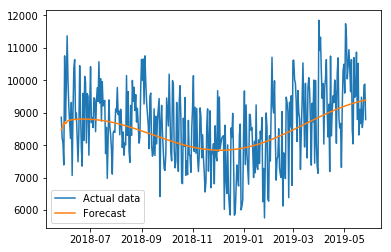

In [10]:
# Prepare the fourier terms to add as exogenous features to auto_arima
# Annual seasonality covered by fourier terms
four_terms = FourierFeaturizer(365.25, 1)
y_prime, exog = four_terms.fit_transform(df["calls"])
exog['date'] = y_prime.index # is exactly the same as manual calculation in the above cells
exog = exog.set_index(exog['date'])
exog.index.freq = 'D'
exog = exog.drop(columns=['date'])


# Split the time series as well as exogenous features data into train and test splits 
y_to_train = y_prime.iloc[:(len(y_prime)-365)]
y_to_test =  y_prime.iloc[(len(y_prime)-365):] # last year for testing

exog_to_train = exog.iloc[:(len(exog)-365)]
exog_to_test = exog.iloc[(len(exog)-365):]


# Fit model
# Weekly seasonality covered by SARIMAX
arima_exog_model = auto_arima(y=y_to_train, exogenous=exog_to_train, seasonal=True, m=7)

# Forecast
y_arima_exog_forecast = arima_exog_model.predict(n_periods=365, exogenous=exog_to_test)
y_arima_exog_forecast = pd.DataFrame(y_arima_exog_forecast , index = pd.date_range(start='2018-05-28', end= '2019-05-27'))


# Plots
plt.plot(y_to_test, label='Actual data')
plt.plot(y_arima_exog_forecast, label='Forecast')
plt.legend()

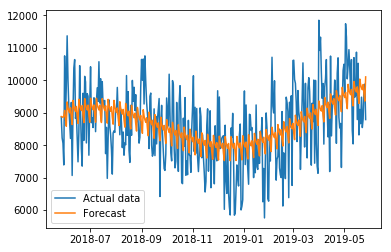

In [39]:
# Prepare the fourier terms to add as exogenous features to auto_arima
# Annual seasonality covered by fourier terms
four_terms = FourierFeaturizer(365.25, 1)
y_prime, exog = four_terms.fit_transform(df["calls"])
exog['date'] = y_prime.index # is exactly the same as manual calculation in the above cells
exog = exog.set_index(exog['date'])
exog.index.freq = 'D'
exog = exog.drop(columns=['date'])


# Split the time series as well as exogenous features data into train and test splits 
y_to_train = y_prime.iloc[:(len(y_prime)-365)]
y_to_test =  y_prime.iloc[(len(y_prime)-365):] # last year for testing

exog_to_train = exog.iloc[:(len(exog)-365)]
exog_to_test = exog.iloc[(len(exog)-365):]


# Fit model
# Weekly seasonality covered by SARIMAX
arima_exog_model = auto_arima(y=y_to_train,D=1, exogenous=exog_to_train, seasonal=True, m=7)
arima_exog_model.summary()
# Forecast
y_arima_exog_forecast = arima_exog_model.predict(n_periods=365, exogenous=exog_to_test)
y_arima_exog_forecast = pd.DataFrame(y_arima_exog_forecast , index = pd.date_range(start='2018-05-28', end= '2019-05-27'))


# Plots
plt.plot(y_to_test, label='Actual data')
plt.plot(y_arima_exog_forecast, label='Forecast')
plt.legend()


In [45]:
y_to_test=pd.DataFrame(y_to_test)


In [43]:
y_to_test

date
2018-05-28     8862.0
2018-05-29     8226.0
2018-05-30     8064.0
2018-05-31     7392.0
2018-06-01    10752.0
2018-06-02     8766.0
2018-06-03     9834.0
2018-06-04    11370.0
2018-06-05    10020.0
2018-06-06     9180.0
2018-06-07     8718.0
2018-06-08     8208.0
2018-06-09     9318.0
2018-06-10     7068.0
2018-06-11     9012.0
2018-06-12    10380.0
2018-06-13    10638.0
2018-06-14     8826.0
2018-06-15     8994.0
2018-06-16     8196.0
2018-06-17     7488.0
2018-06-18     8382.0
2018-06-19    10452.0
2018-06-20     9060.0
2018-06-21     7902.0
2018-06-22     7356.0
2018-06-23     9600.0
2018-06-24     8148.0
2018-06-25    10122.0
2018-06-26     9948.0
               ...   
2019-04-28     7314.0
2019-04-29     9192.0
2019-04-30    10296.0
2019-05-01    10494.0
2019-05-02     9606.0
2019-05-03    11742.0
2019-05-04    11334.0
2019-05-05    10044.0
2019-05-06    10464.0
2019-05-07    10944.0
2019-05-08    10368.0
2019-05-09     9648.0
2019-05-10    10638.0
2019-05-11     8454.0
2019-

In [24]:
y_to_test.index

DatetimeIndex(['2018-05-28', '2018-05-29', '2018-05-30', '2018-05-31',
               '2018-06-01', '2018-06-02', '2018-06-03', '2018-06-04',
               '2018-06-05', '2018-06-06',
               ...
               '2019-05-18', '2019-05-19', '2019-05-20', '2019-05-21',
               '2019-05-22', '2019-05-23', '2019-05-24', '2019-05-25',
               '2019-05-26', '2019-05-27'],
              dtype='datetime64[ns]', name='date', length=365, freq='D')

In [ ]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))

test.plot(x='ds',y='y',label='True Miles',legend=True,ax=ax,xlim=('2018-01-01','2019-01-01'))

AttributeError: Unknown property xlim

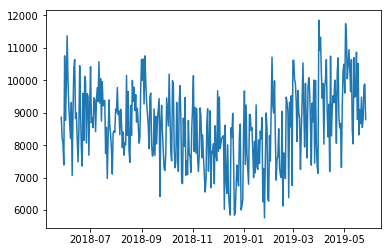

In [18]:
plt.plot(y_to_test, label='Actual data')
plt.plot(y_arima_exog_forecast, label='Forecast', xlim=('2018-05-28','2019-05-27'))
plt.legend()

ax =plt.plot(y_to_test, label='Actual data',label='testdata', legend=True, figsize=(12,8))

test.plot(x='ds',y='y',label='True Miles',legend=True,ax=ax,xlim=('2018-01-01','2019-01-01'))
